In [ ]:
!apt-get install -y ffmpeg
!pip install -q transformers torch librosa soundfile accelerate diffusers
!pip install -q openai-whisper pydub

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
import os
import sys
import torch
import warnings
from IPython.display import display, Markdown, Audio, HTML, Image as IPImage
import json

warnings.filterwarnings("ignore")

# 環境檢查

In [ ]:
print("=" * 70)
print("🔍 系統環境檢查")
print("=" * 70)

required_packages = {
    "transformers": "transformers",
    "torch": "torch",
    "whisper": "openai-whisper",
    "soundfile": "soundfile",
    "librosa": "librosa",
    "pydub": "pydub",
    "diffusers": "diffusers"
}

missing = []
for module, package in required_packages.items():
    try:
        __import__(module)
        print(f"✅ {package}")
    except ImportError:
        missing.append(package)
        print(f"❌ {package} 未安裝")

if missing:
    print(f"\n⚠️  缺少套件: {', '.join(missing)}")
    print("\n請執行：")
    print("!apt-get install -y ffmpeg")
    print("!pip install -q transformers torch librosa soundfile accelerate diffusers")
    print("!pip install -q openai-whisper pydub")
    sys.exit(1)

from google.colab import files
import whisper
from transformers import pipeline
import soundfile as sf
from pydub import AudioSegment
import librosa
import numpy as np
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n🖥️  運算設備: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   記憶體: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print("=" * 70 + "\n")

🔍 系統環境檢查
✅ transformers
✅ torch
✅ openai-whisper
✅ soundfile
✅ librosa
✅ pydub
✅ diffusers

🖥️  運算設備: cuda
   GPU: Tesla T4
   記憶體: 15.8 GB



# 模型載入

In [ ]:
print("📦 正在載入 AI 模型...\n")

# 1. Whisper
whisper_model = None
WHISPER_SIZE = "medium"

print(f"1️⃣  Whisper 語音辨識 ({WHISPER_SIZE})")
print("   載入中...")
try:
    whisper_model = whisper.load_model(WHISPER_SIZE, device=DEVICE)
    print("   ✅ 載入成功\n")
except:
    try:
        WHISPER_SIZE = "small"
        whisper_model = whisper.load_model(WHISPER_SIZE, device=DEVICE)
        print("   ✅ small 模型載入成功\n")
    except Exception as e:
        print(f"   ❌ 失敗: {e}\n")

# 2. 情緒分析
emotion_classifier = None
print("2️⃣  多維度情緒分析")
print("   載入中...")
try:
    emotion_classifier = pipeline(
        "text-classification",
        model="j-hartmann/emotion-english-distilroberta-base",
        device=0 if DEVICE == "cuda" else -1,
        return_all_scores=True
    )
    print("   ✅ 載入成功\n")
except:
    try:
        emotion_classifier = pipeline(
            "sentiment-analysis",
            model="cardiffnlp/twitter-roberta-base-sentiment-latest",
            device=0 if DEVICE == "cuda" else -1,
        )
        print("   ✅ 備用模型載入成功\n")
    except Exception as e:
        print(f"   ❌ 失敗: {e}\n")

# 3. Stable Diffusion (可選)
sd_pipe = None
USE_SD = True  # 設為 True 啟用 AI 生圖

if USE_SD and DEVICE == "cuda":
    print("3️⃣  Stable Diffusion AI 繪圖模型")
    print("   ⏳ 載入中（需 2-5 分鐘，請耐心等待）...")
    try:
        model_id = "runwayml/stable-diffusion-v1-5"
        sd_pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16,
            safety_checker=None,  # 加速載入
        )
        sd_pipe.scheduler = DPMSolverMultistepScheduler.from_config(sd_pipe.scheduler.config)
        sd_pipe = sd_pipe.to(DEVICE)
        sd_pipe.enable_attention_slicing()  # 節省記憶體
        print("   ✅ 載入成功！可以直接生圖\n")
    except Exception as e:
        print(f"   ⚠️  載入失敗: {e}")
        print("   將僅提供提示詞，不進行直接生圖\n")
        USE_SD = False
else:
    if DEVICE == "cpu":
        print("3️⃣  ⚠️  未偵測到 GPU，跳過 SD 載入（CPU 生圖太慢）\n")
    else:
        print("3️⃣  ℹ️  Stable Diffusion 已停用（可在代碼中設定 USE_SD=True 啟用）\n")

print("=" * 70)
print("✅ 模型載入完成")
print("=" * 70 + "\n")


📦 正在載入 AI 模型...

1️⃣  Whisper 語音辨識 (medium)
   載入中...
   ✅ 載入成功

2️⃣  多維度情緒分析
   載入中...


Device set to use cuda:0


   ✅ 載入成功

3️⃣  Stable Diffusion AI 繪圖模型
   ⏳ 載入中（需 2-5 分鐘，請耐心等待）...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


   ✅ 載入成功！可以直接生圖

✅ 模型載入完成



# 情緒資料庫

In [ ]:
EMOTION_DATABASE = {
    "anger": {
        "zh": "憤怒",
        "visual": "眉頭緊皺、咬牙切齒、臉色漲紅",
        "effects": "fire, lightning, explosion effects",
        "colors": ["red", "dark orange", "black"],
        "style_keywords": "angry, furious, intense, aggressive",
    },
    "disgust": {
        "zh": "厭惡",
        "visual": "皺鼻子、嘴角下垂、後退姿態",
        "effects": "wavy lines, X marks, avoiding gesture",
        "colors": ["dark green", "purple grey", "brown"],
        "style_keywords": "disgusted, repulsed, uncomfortable",
    },
    "fear": {
        "zh": "恐懼",
        "visual": "眼睛睜大、身體顫抖、冷汗直流",
        "effects": "shadows, zigzag lines, sweat drops",
        "colors": ["dark blue", "purple", "grey"],
        "style_keywords": "scared, frightened, anxious, worried",
    },
    "joy": {
        "zh": "喜悅",
        "visual": "笑容燦爛、眼睛彎彎、手舞足蹈",
        "effects": "stars, hearts, sparkles, shine effects",
        "colors": ["bright yellow", "pink", "light blue"],
        "style_keywords": "happy, joyful, cheerful, delighted, smiling",
    },
    "neutral": {
        "zh": "平靜",
        "visual": "表情自然、眼神平和、姿態放鬆",
        "effects": "simple lines, geometric shapes",
        "colors": ["light blue", "white", "grey"],
        "style_keywords": "calm, peaceful, neutral, relaxed",
    },
    "sadness": {
        "zh": "悲傷",
        "visual": "眼角下垂、嘴角下彎、低頭不語",
        "effects": "tears, rain drops, dark clouds",
        "colors": ["dark blue", "grey blue", "light purple"],
        "style_keywords": "sad, melancholic, crying, depressed",
    },
    "surprise": {
        "zh": "驚訝",
        "visual": "眼睛睜大、嘴巴張開、身體後仰",
        "effects": "exclamation marks, lightning, burst effects",
        "colors": ["bright orange", "yellow", "white"],
        "style_keywords": "surprised, shocked, amazed, astonished",
    }
}

EMOTION_FALLBACK = {
    "positive": "joy", "negative": "sadness", "POSITIVE": "joy",
    "NEGATIVE": "sadness", "NEUTRAL": "neutral", "neutral": "neutral"
}

# 核心函數

In [ ]:
def convert_audio_to_wav(audio_path):
    """轉換音檔格式"""
    file_ext = os.path.splitext(audio_path)[1].lower()
    audio_extensions = ['.mp3', '.wav', '.m4a', '.flac', '.ogg', '.aac', '.wma', '.opus', '.webm']

    if file_ext not in audio_extensions:
        print(f"   ❌ 錯誤：{file_ext} 不是音檔格式")
        return None

    if file_ext == '.wav':
        return audio_path

    print(f"   🔄 轉換 {file_ext} → WAV...")
    try:
        audio = AudioSegment.from_file(audio_path)
        wav_path = audio_path.rsplit('.', 1)[0] + '_converted.wav'
        audio.export(wav_path, format='wav')
        print(f"   ✅ 轉換完成")
        return wav_path
    except Exception as e:
        try:
            y, sr = librosa.load(audio_path, sr=None)
            wav_path = audio_path.rsplit('.', 1)[0] + '_converted.wav'
            sf.write(wav_path, y, sr)
            print(f"   ✅ 轉換完成（librosa）")
            return wav_path
        except Exception as e2:
            print(f"   ❌ 轉換失敗: {str(e2)}")
            return None

def transcribe_audio_enhanced(audio_path):
    """增強版語音轉文字"""
    if not whisper_model:
        return None

    print("\n" + "=" * 70)
    print("🎤 步驟 1: 高精度語音轉文字")
    print("=" * 70)

    try:
        result = whisper_model.transcribe(
            audio_path,
            language="zh",
            task="transcribe",
            fp16=(DEVICE == "cuda"),
            temperature=0.0,
            beam_size=5,
            best_of=5,
            patience=1.0,
            condition_on_previous_text=True,
            initial_prompt="以下是普通話的句子。",
        )
        return result
    except Exception as e:
        print(f"❌ 轉錄失敗: {e}")
        return None

def analyze_emotions_multi(text):
    """多維度情緒分析"""
    if not emotion_classifier:
        return None

    print("\n" + "=" * 70)
    print("🧠 步驟 2: 多維度情緒分析")
    print("=" * 70)

    try:
        results = emotion_classifier(text[:512])
        if isinstance(results[0], list):
            emotions = results[0]
            return sorted(emotions, key=lambda x: x['score'], reverse=True)
        else:
            label = results[0]['label']
            score = results[0]['score']
            standard_label = EMOTION_FALLBACK.get(label, "neutral")
            return [{"label": standard_label, "score": score}]
    except Exception as e:
        print(f"❌ 情緒分析失敗: {e}")
        return None

def generate_detailed_prompts(text, emotions, confidence):
    """生成詳細的中英文生圖提示詞"""

    if not emotions:
        return None

    primary = emotions[0]
    primary_label = EMOTION_FALLBACK.get(primary['label'], primary['label'])
    emotion_data = EMOTION_DATABASE.get(primary_label, EMOTION_DATABASE["neutral"])

    # 中文詳細提示詞
    chinese_prompt = f"""## 🎨 AI 生圖提示詞（中文版）

**角色設計**:
- 可愛的 Q 版卡通角色，表現出【{emotion_data['zh']}】情緒
- 表情特徵：{emotion_data['visual']}
- 情緒強度：{confidence:.1%}

**視覺風格**:
- 風格：Line 貼圖風格、扁平化設計、粗黑邊框
- 配色方案：{', '.join(emotion_data['colors'])}為主色調
- 特效：{emotion_data['effects']}

**文字元素**:
- 標語文字：「{text}」
- 字體：粗體、清晰、易讀
- 位置：角色下方或周圍

**畫面構成**:
- 背景：純色或漸層，{emotion_data['colors'][0]}系
- 尺寸：512x512 像素，正方形構圖
"""

    # 英文詳細提示詞
    english_prompt = f"""## 🎨 AI Image Generation Prompt (English)

A cute chibi cartoon character expressing **{emotion_data['zh']} ({primary_label})** emotion.

**Character Design**:
- Facial expression: {emotion_data['visual']}
- Emotion intensity: {confidence:.1%}

**Visual Style**:
- Style: LINE sticker style, flat design, bold black outlines
- Color scheme: {', '.join(emotion_data['colors'])}
- Effects: {emotion_data['effects']}

**Text Element**:
- Speech bubble or caption with: "{text}"
- Font: Bold, clear, easy to read

**Composition**:
- Background: Solid color or gradient, {emotion_data['colors'][0]} tone
- Size: 512x512 pixels, square format

**Keywords**: cute, chibi, cartoon sticker, {emotion_data['style_keywords']}, expressive, messaging app
"""

    # 一鍵複製的簡潔版提示詞（給 SD 用）
    simple_positive = f"""cute chibi cartoon character sticker, {emotion_data['style_keywords']}, text "{text}",
LINE sticker style, bold black outlines, flat design, {' and '.join(emotion_data['colors'])} colors,
{emotion_data['effects']}, white background, 512x512, high quality, vector art,
{emotion_data['visual']}, messaging app sticker, professional"""

    simple_negative = """ugly, deformed, blurry, bad anatomy, bad proportions, extra limbs,
cloned face, disfigured, missing arms, missing legs, extra arms, extra legs,
fused fingers, too many fingers, low quality, jpeg artifacts, watermark, signature"""

    return {
        "chinese_detailed": chinese_prompt,
        "english_detailed": english_prompt,
        "simple_positive": simple_positive,
        "simple_negative": simple_negative,
        "emotion_data": emotion_data
    }

def generate_image_with_sd(prompt_data, text):
    """使用 Stable Diffusion 生成圖片"""

    if not sd_pipe:
        return None

    print("\n" + "=" * 70)
    print("🎨 步驟 3: AI 繪圖生成中...")
    print("=" * 70)
    print("⏳ 生成中（約需 30-60 秒）...")

    try:
        image = sd_pipe(
            prompt=prompt_data["positive"],
            negative_prompt=prompt_data["negative"],
            num_inference_steps=30,
            guidance_scale=7.5,
            width=512,
            height=512,
        ).images[0]

        print("✅ 圖片生成完成！\n")
        return image

    except Exception as e:
        print(f"❌ 生成失敗: {e}\n")
        return None

# 主程式


# 🎙️ 音檔智能分析 + AI 生圖系統

## ✨ 功能：
- 🎯 高精度語音辨識（Whisper medium）
- 🧠 多維度情緒分析（7 種情緒）
- 📝 詳細情緒描述 + 生圖建議
- 🎨 **一鍵複製提示詞**
- 🖼️ **直接 AI 生圖**（Stable Diffusion）

## 📤 請上傳音檔
支援：`.mp3`, `.wav`, `.m4a`, `.flac`, `.ogg`, `.aac` 等

⚠️ 請勿上傳圖片（.png, .jpg）或文件


Saving b56094681ebb091df3959c7100da7930.mp3 to b56094681ebb091df3959c7100da7930.mp3


### ✅ 已上傳音檔: `b56094681ebb091df3959c7100da7930.mp3`


   🔄 轉換 .mp3 → WAV...
   ✅ 轉換完成

🎤 步驟 1: 高精度語音轉文字
✅ 轉錄完成
   文字: 沒出息!



---
## 📝 語音轉文字結果
> **「沒出息!」**

- 偵測語言: zh
- 字元數: 4



🧠 步驟 2: 多維度情緒分析
✅ 情緒分析完成


---
## 🧠 情緒分析結果



### 主要情緒: 憤怒 (68.1%)

**視覺特徵**: 眉頭緊皺、咬牙切齒、臉色漲紅  
**建議配色**: red, dark orange, black  
**特效元素**: fire, lightning, explosion effects



---
## 🎨 AI 生圖提示詞

### 📋 正面提示詞（直接複製使用）：


### 🚫 負面提示詞：


---
## 🖼️ AI 生圖結果


Token indices sequence length is longer than the specified maximum sequence length for this model (123 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['expressive face , 眉 頭 緊 皺 、 咬 牙 切 齒 、 臉 色 漲 紅 , messaging app sticker , professional illustration']



🎨 步驟 3: AI 繪圖生成中...
⏳ 生成中（約需 30-60 秒）...


  0%|          | 0/30 [00:00<?, ?it/s]

✅ 圖片生成完成！



### ✅ 貼圖生成成功！


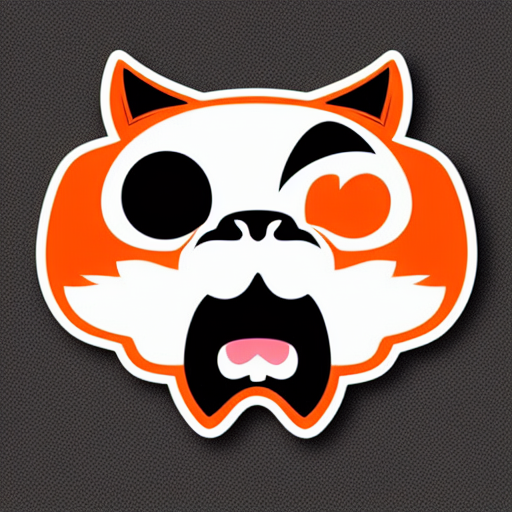


### 📥 下載貼圖

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


---
### 💡 提示
- 如果效果不理想，可以調整提示詞後重新生成
- 或使用提示詞到其他 AI 繪圖平台（Midjourney、Leonardo.ai）



✅ 處理完成


In [ ]:
def main():
    """主程式"""

    if not whisper_model:
        display(Markdown("## ❌ Whisper 模型未載入"))
        return

    display(Markdown(f"""
# 🎙️ 音檔智能分析 + AI 生圖系統

## ✨ 功能：
- 🎯 高精度語音辨識（Whisper {WHISPER_SIZE}）
- 🧠 多維度情緒分析（7 種情緒）
- 📝 詳細情緒描述 + 生圖建議
- 🎨 **一鍵複製提示詞**
{"- 🖼️ **直接 AI 生圖**（Stable Diffusion）" if USE_SD and sd_pipe else "- ⚠️ AI 生圖功能未啟用（需 GPU）"}

## 📤 請上傳音檔
支援：`.mp3`, `.wav`, `.m4a`, `.flac`, `.ogg`, `.aac` 等

⚠️ 請勿上傳圖片（.png, .jpg）或文件
"""))

    # 上傳
    try:
        uploaded = files.upload()
    except:
        return

    if not uploaded:
        return

    filename = list(uploaded.keys())[0]

    # 檢查檔案類型
    file_ext = os.path.splitext(filename)[1].lower()
    audio_extensions = ['.mp3', '.wav', '.m4a', '.flac', '.ogg', '.aac', '.wma', '.opus', '.webm']

    if file_ext not in audio_extensions:
        display(Markdown(f"""
## ❌ 檔案類型錯誤

您上傳的是 **{file_ext}** 檔案，不是音檔！

請上傳音檔格式：`.mp3`, `.wav`, `.m4a` 等
"""))
        os.remove(filename)
        return

    display(Markdown(f"### ✅ 已上傳音檔: `{filename}`\n"))

    try:
        display(Audio(filename, autoplay=False))
    except:
        pass

    # 轉換
    wav_path = convert_audio_to_wav(filename)
    if not wav_path:
        os.remove(filename)
        return

    # === 語音轉文字 ===
    whisper_result = transcribe_audio_enhanced(wav_path)
    if not whisper_result:
        if wav_path != filename:
            os.remove(wav_path)
        os.remove(filename)
        return

    text = whisper_result["text"].strip()
    language = whisper_result.get("language", "未知")

    print(f"✅ 轉錄完成")
    print(f"   文字: {text}")

    display(Markdown(f"""
---
## 📝 語音轉文字結果
> **「{text}」**

- 偵測語言: {language}
- 字元數: {len(text)}
"""))

    # === 情緒分析 ===
    emotions = analyze_emotions_multi(text)

    if not emotions:
        display(Markdown("### ⚠️ 情緒分析失敗"))
        if wav_path != filename:
            os.remove(wav_path)
        os.remove(filename)
        return

    print(f"✅ 情緒分析完成")

    # 顯示情緒分析
    display(Markdown("---\n## 🧠 情緒分析結果\n"))

    primary = emotions[0]
    primary_label = EMOTION_FALLBACK.get(primary['label'], primary['label'])
    emotion_data = EMOTION_DATABASE.get(primary_label, EMOTION_DATABASE["neutral"])

    display(Markdown(f"""
### 主要情緒: {emotion_data['zh']} ({primary['score']:.1%})

**視覺特徵**: {emotion_data['visual']}
**建議配色**: {', '.join(emotion_data['colors'])}
**特效元素**: {emotion_data['effects']}
"""))

    # === 生成提示詞 ===
    prompt_data = generate_final_prompt(text, emotions)

    display(Markdown("""
---
## 🎨 AI 生圖提示詞

### 📋 正面提示詞（直接複製使用）：
"""))

    # 可複製的提示詞框
    display(HTML(f"""
    <div style='background: #f8f9fa; padding: 15px; border-radius: 8px; border-left: 4px solid #28a745; margin: 10px 0;'>
        <code style='font-size: 14px; white-space: pre-wrap; word-break: break-word;'>{prompt_data['positive']}</code>
    </div>
    """))

    display(Markdown("### 🚫 負面提示詞："))
    display(HTML(f"""
    <div style='background: #fff3cd; padding: 15px; border-radius: 8px; border-left: 4px solid #ffc107; margin: 10px 0;'>
        <code style='font-size: 14px; white-space: pre-wrap; word-break: break-word;'>{prompt_data['negative']}</code>
    </div>
    """))

    # === AI 生圖 ===
    if USE_SD and sd_pipe:
        display(Markdown("\n---\n## 🖼️ AI 生圖結果\n"))

        generated_image = generate_image_with_sd(prompt_data, text)

        if generated_image:
            # 儲存圖片
            output_filename = f"sticker_{text[:10].replace(' ', '_')}.png"
            generated_image.save(output_filename)

            display(Markdown("### ✅ 貼圖生成成功！\n"))
            display(generated_image)

            # 下載按鈕
            display(Markdown("\n### 📥 下載貼圖"))
            files.download(output_filename)

            display(Markdown("""
---
### 💡 提示
- 如果效果不理想，可以調整提示詞後重新生成
- 或使用提示詞到其他 AI 繪圖平台（Midjourney、Leonardo.ai）
"""))
        else:
            display(Markdown("""
### ⚠️ 生圖失敗

請使用上方的提示詞到其他平台生成：
- [Leonardo.ai](https://leonardo.ai)
- [Playground AI](https://playgroundai.com)
- [Midjourney](https://midjourney.com)
"""))
    else:
        display(Markdown("""
---
## 💡 使用提示詞

複製上方的**正面提示詞**和**負面提示詞**，到以下平台生成：

### 推薦平台：
- 🎨 **Leonardo.ai** - 免費，質量高
- 🎨 **Playground AI** - 免費
- 🎨 **Midjourney** - 付費，最專業
- 🎨 **DALL-E 3** - ChatGPT Plus 內建

### 生成設定建議：
- 尺寸：512x512
- 步數：30-50
- CFG Scale：7-8
- 採樣器：DPM++ 2M Karras
"""))

    # 清理
    if wav_path != filename:
        os.remove(wav_path)
    os.remove(filename)
    print("\n✅ 處理完成")

if __name__ == "__main__":
    main()